# Pipeline Introduction


Follow _Introduction to Machine Learning_ [Chapter 6](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb):
-  6. Algorithm Chains and Pipelines to 6.4 The General Pipeline interface 





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mglearn

As an example of the importance of chaining models, we noticed that we can greatly improve the performance of a kernel SVM on the `cancer` dataset by using the `MinMaxScaler` for preprocessing. Here’s code for splitting the data, computing the minimum and maximum, scaling the data, and training the SVM:

## Scaling -> classification  on breast cancer dataset (review)

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [4]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


## Using grid search to find better parameters - Naive approach

Now let’s say we want to find better parameters for SVC using GridSearchCV. How should we go about doing this? A naive approach might look like this:

In [5]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


- When scaling the data, we used all the data in the training set to compute the minimum and maximum of the data
- We then use the scaled training data to run our grid search using cross-validation

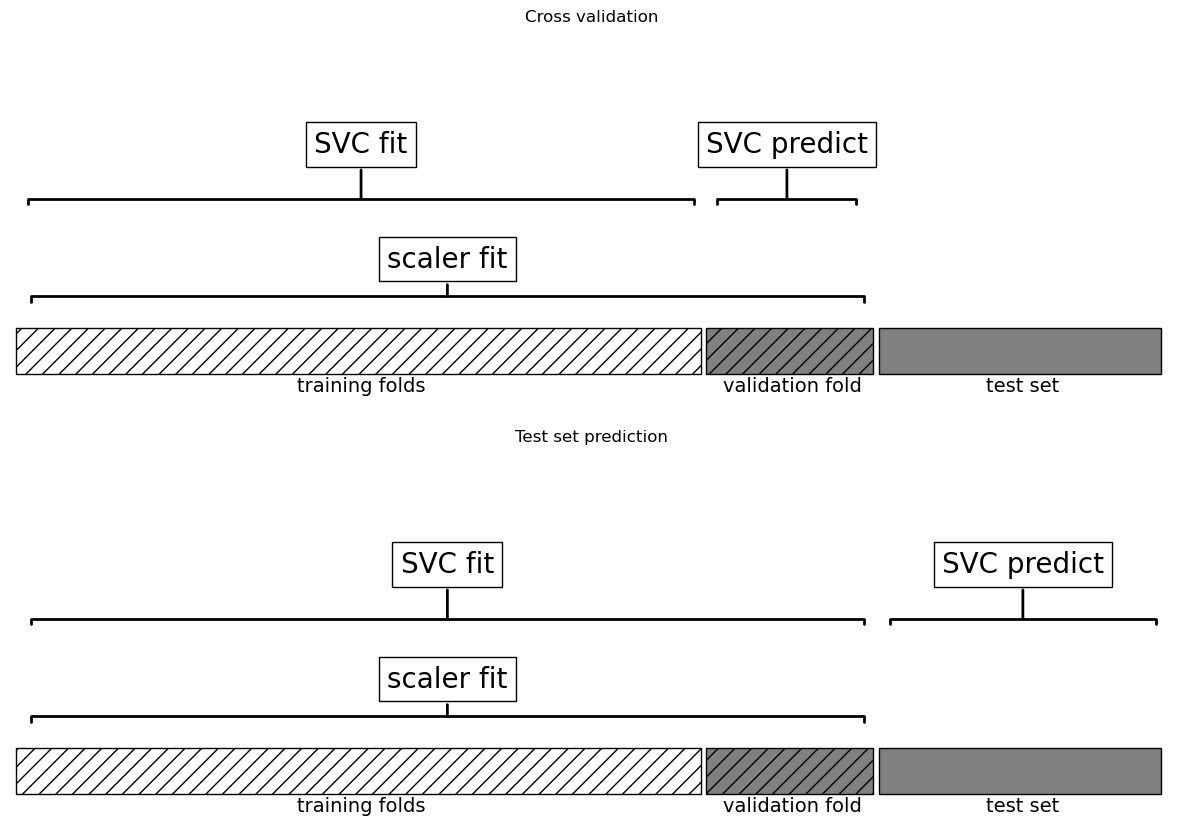

In [6]:
mglearn.plots.plot_improper_processing()

>So, the splits in the cross-validation no longer correctly mirror how new data will look to the modeling process. We already leaked information from these parts of the data into our modeling process. This will lead to overly optimistic results during cross-validation, and possibly the selection of suboptimal parameters.

## ILLUSTRATING INFORMATION LEAKAGE 
>Let’s consider a synthetic regression task with 100 samples and 10,000 features that are sampled independently from a Gaussian distribution. We also sample the response from a Gaussian distribution:

In [7]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

>Given the way we created the dataset, there is no relation between the data, X, and the target, y (they are independent), so it should not be possible to learn anything from this dataset.

>First, select the most informative of the 10,000 features using SelectPercentile feature selection, and then we evaluate a Ridge regressor using cross-validation:

In [8]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


> The mean R2 computed by cross-validation is 0.91, indicating a very good model. This clearly cannot be right, as our data is entirely random. 

>Let’s compare this to a proper cross-validation using a pipeline:

In [10]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


>This time, we get a negative R2 score, indicating a very poor model. Using the pipeline, the feature selection is now inside the cross-validation loop. This means features can only be selected using the training folds of the data, not the test fold.

>The feature selection finds features that are correlated with the target on the training set, but because the data is entirely random, these features are not correlated with the target on the test set. In this example, rectifying the data leakage issue in the feature selection makes the difference between concluding that a model works very well and concluding that a model works not at all.

## Building pipelines

In [11]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [12]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [13]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


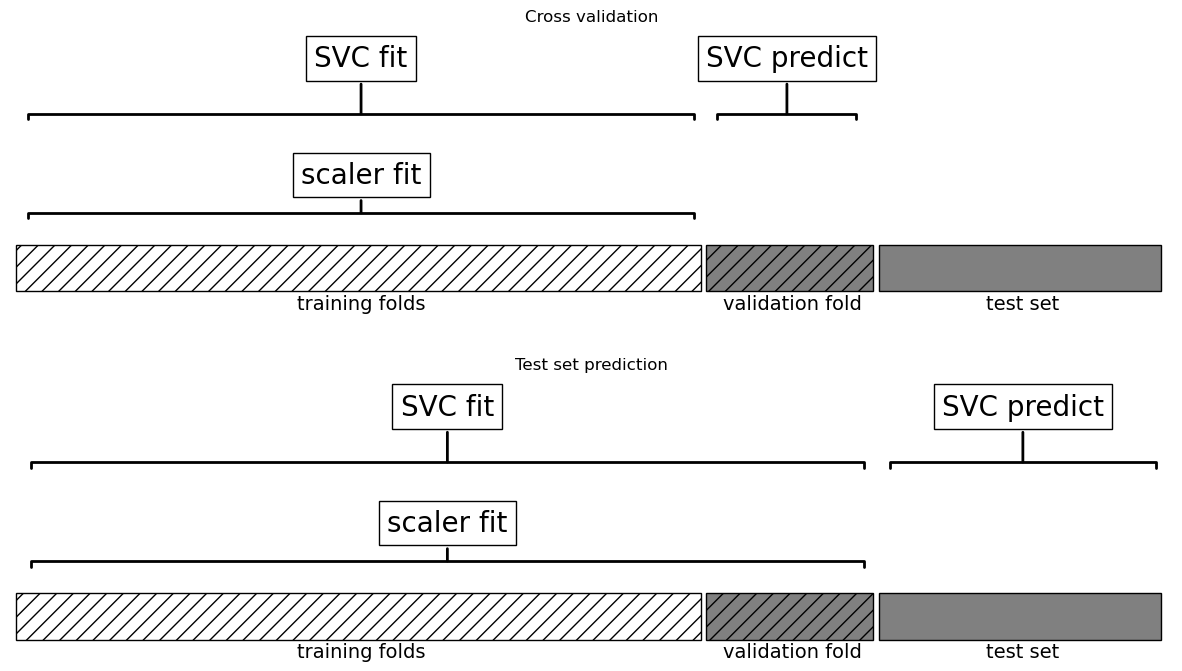

In [14]:
mglearn.plots.plot_proper_processing()

>Calling the score method on the pipeline first transforms the test data using the scaler, and then calls the score method on the SVM using the scaled test data. As you can see, the result is identical to the one we got from the code at the beginning of the chapter, when doing the transformations by hand. Using the pipeline, we reduced the code needed for our “preprocessing + classification” process. The main benefit of using the pipeline, however, is that we can now use this single estimator in cross_val_score or GridSearchCV.

## Using pipelines in grid searches

We use the named step in the pipeline, followed by two underscores, then the hyper-parameter name to define the grid parameters:

In [15]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [16]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


![](pipeline.png)